# **Hourly Time Series Forecasting using Meta Prophet**

### Background on the Types of Time Series Data
<img title="TimeSeriesData" alt="timeSereieData" src="../forecast/assets/timeseriesData.jpg">

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from prophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

**Mean Absolute Percentage Error (MAPE)** measures the accuracy of a forecasting model by calculating the average absolute percentage difference between predicted and actual values over a series of time periods. It's expressed as a percentage, which makes it easy to interpret, and is particularly useful for comparing model performance accross datasets with different scales. For example, a MAPE of 10% means the average error was 10% of the actual values

$$ MAPE = 100 \frac{1}{n} \sum_{t-1}^n \Bigg|\frac{A_t - F_t}{A_t}\Bigg| $$

In [4]:
def mean_absolute_percentage_error(y_true, y_pred):
    """Calculate MAPE give y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## **Data**
The data we will be using is hourly power consumption data from PJM. Energy consumption has some unique characteristics. It will be interesting to see how prophet picks them up. 

Pulling the `PJM East` which has data from 2002-2018 for the entire east region.

```python
import kagglehub

# Download latest version
path = kagglehub.dataset_download("robikscube/hourly-energy-consumption")

print("Path to dataset files:", path)
```

In [5]:
pjme = pd.read_csv(
    "./data/PJME_hourly.csv",
    index_col=[0],
    parse_dates=[0]
)
pjme.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [208]:
pjme = pjme.sort_index()

In [209]:
pjme.head()

,PJME_MW
Datetime,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0


In [210]:
pjme.tail()

,PJME_MW
Datetime,
2018-08-02 20:00:00,44057.0
2018-08-02 21:00:00,43256.0
2018-08-02 22:00:00,41552.0
2018-08-02 23:00:00,38500.0
2018-08-03 00:00:00,35486.0


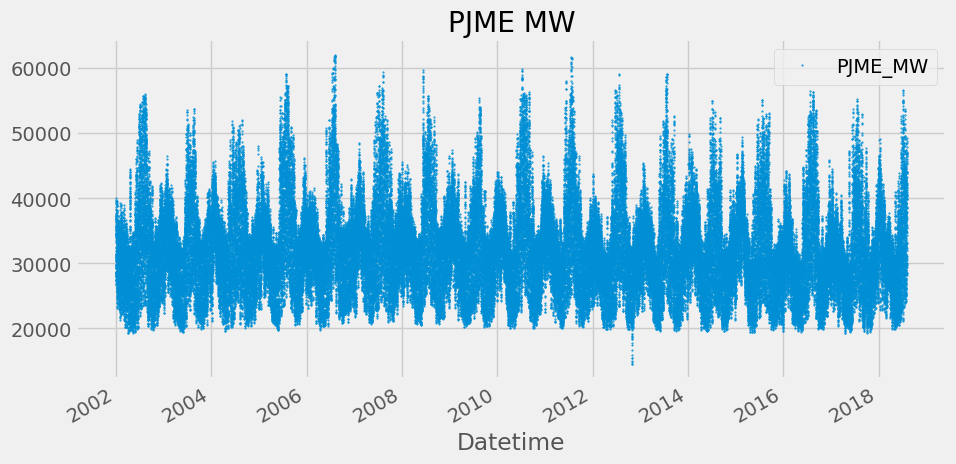

In [211]:
color_pal = sns.color_palette()
pjme.plot(
    style='.',
    figsize=(10, 5), 
    ms=1, 
    color=color_pal[0],
    title="PJME MW"
)

plt.show()


## **Time Sereies Feature**

In [212]:
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(
    categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], 
    ordered=True
)

def create_features(df, label=None):
    """ Creates time series features from datetime index."""
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320)%1300
    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300], labels=['Spring', 'Summer', 'Fall', 'Winter'])

    X = df[['hour', 'dayofweek','quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear', 'weekday', 'season']]

    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(pjme, label='PJME_MW')
features_and_target = pd.concat([X, y], axis=1)

In [213]:
features_and_target

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,weekday,season,PJME_MW
Datetime,,,,,,,,,,,
2002-01-01 01:00:00,1,1,1,1,2002,1,1,1,Tuesday,Winter,30393.0
2002-01-01 02:00:00,2,1,1,1,2002,1,1,1,Tuesday,Winter,29265.0
2002-01-01 03:00:00,3,1,1,1,2002,1,1,1,Tuesday,Winter,28357.0
2002-01-01 04:00:00,4,1,1,1,2002,1,1,1,Tuesday,Winter,27899.0
2002-01-01 05:00:00,5,1,1,1,2002,1,1,1,Tuesday,Winter,28057.0
...,...,...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,20,3,3,8,2018,214,2,31,Thursday,Summer,44057.0
2018-08-02 21:00:00,21,3,3,8,2018,214,2,31,Thursday,Summer,43256.0
2018-08-02 22:00:00,22,3,3,8,2018,214,2,31,Thursday,Summer,41552.0


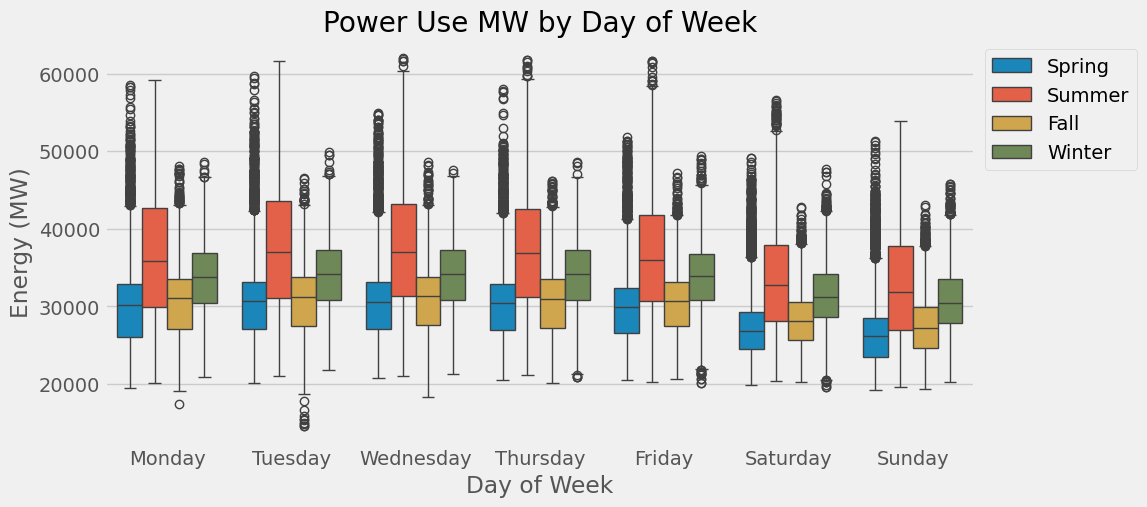

In [214]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=features_and_target.dropna(),
            x='weekday',
            y='PJME_MW',
            hue='season',
            ax=ax,
            linewidth=1)
ax.set_title('Power Use MW by Day of Week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Energy (MW)')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

## **Train / Test Split**

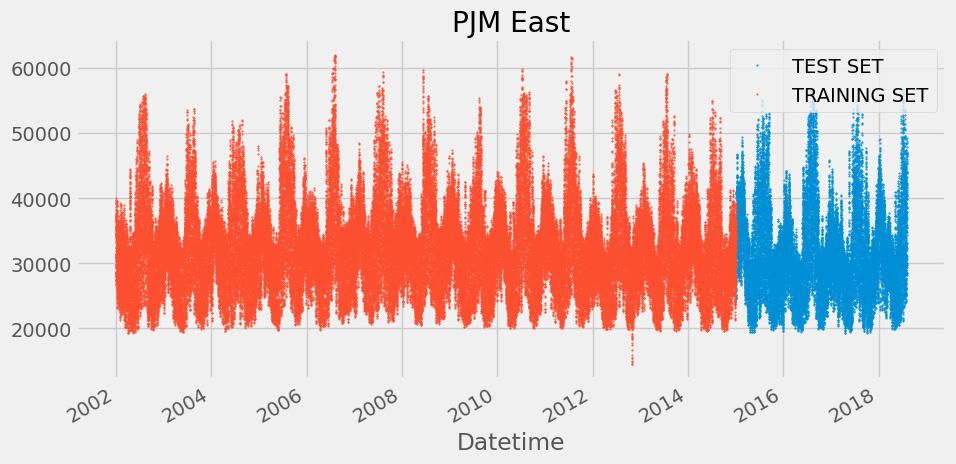

In [215]:
split_date = '1-Jan-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

# Plot train and test so you can see where we have split
pjme_test.rename(columns={'PJME_MW': 'TEST SET'}).join(
    pjme_train.rename(
        columns={'PJME_MW':'TRAINING SET'}),
          how='outer').plot(figsize=(10, 5), title="PJM East", style = '.', ms=1)

plt.show()

In [216]:
pjme.shape[0] == pjme_test.shape[0] + pjme_train.shape[0]

True

In [220]:
pjme_train.tail(2)

,PJME_MW
Datetime,
2014-12-31 23:00:00,34003.0
2015-01-01 00:00:00,32802.0


In [221]:
pjme_test.head(3)

,PJME_MW
Datetime,
2015-01-01 01:00:00,31647.0
2015-01-01 02:00:00,30755.0
2015-01-01 03:00:00,30189.0


## **Simple Prophet Model**
* Prophet model expects the dataset to be named a specific way. We will rename our dataframe columns before feeding into the model.
  * Datetime column named: $ds$
  * target: $y$

In [222]:
# Format data for prophet model using ds and y
pjme_train_prophet = pjme_train.reset_index().rename(
    columns={'Datetime':'ds',
             'PJME_MW':'y'})

In [223]:
pjme_train_prophet

,ds,y
0,2002-01-01 01:00:00,30393.0
1,2002-01-01 02:00:00,29265.0
2,2002-01-01 03:00:00,28357.0
3,2002-01-01 04:00:00,27899.0
4,2002-01-01 05:00:00,28057.0
...,...,...
113922,2014-12-31 20:00:00,37772.0
113923,2014-12-31 21:00:00,36602.0
113924,2014-12-31 22:00:00,35326.0
113925,2014-12-31 23:00:00,34003.0


In [224]:
%%time
model = Prophet()
model.fit(pjme_train_prophet)

17:50:39 - cmdstanpy - INFO - Chain [1] start processing
17:51:19 - cmdstanpy - INFO - Chain [1] done processing


CPU times: user 2.43 s, sys: 79.3 ms, total: 2.51 s
Wall time: 43.1 s


In [225]:
# Predict on test set with model
pjme_test_prophet = pjme_test.reset_index().rename(
    columns={'Datetime':'ds', 
             'PJME_MW':'y'})
pjme_test_fcst = model.predict(pjme_test_prophet)

In [226]:
pjme_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 01:00:00,31218.811997,24282.755728,32482.562638,31218.811997,31218.811997,-2843.772061,-2843.772061,-2843.772061,-4430.340461,-4430.340461,-4430.340461,1281.389092,1281.389092,1281.389092,305.179308,305.179308,305.179308,0.0,0.0,0.0,28375.039936
1,2015-01-01 02:00:00,31218.775729,22567.066908,31337.258044,31218.775729,31218.775729,-4348.135158,-4348.135158,-4348.135158,-5927.249926,-5927.249926,-5927.249926,1272.631905,1272.631905,1272.631905,306.482862,306.482862,306.482862,0.0,0.0,0.0,26870.640570
2,2015-01-01 03:00:00,31218.739461,21726.838832,30759.908050,31218.739461,31218.739461,-5219.824952,-5219.824952,-5219.824952,-6790.321820,-6790.321820,-6790.321820,1262.668947,1262.668947,1262.668947,307.827920,307.827920,307.827920,0.0,0.0,0.0,25998.914508
3,2015-01-01 04:00:00,31218.703193,21562.547027,30090.154289,31218.703193,31218.703193,-5361.373607,-5361.373607,-5361.373607,-6922.211926,-6922.211926,-6922.211926,1251.623808,1251.623808,1251.623808,309.214510,309.214510,309.214510,0.0,0.0,0.0,25857.329585
4,2015-01-01 05:00:00,31218.666925,21967.496182,30983.024660,31218.666925,31218.666925,-4687.034476,-4687.034476,-4687.034476,-6237.309420,-6237.309420,-6237.309420,1239.632289,1239.632289,1239.632289,310.642656,310.642656,310.642656,0.0,0.0,0.0,26531.632449


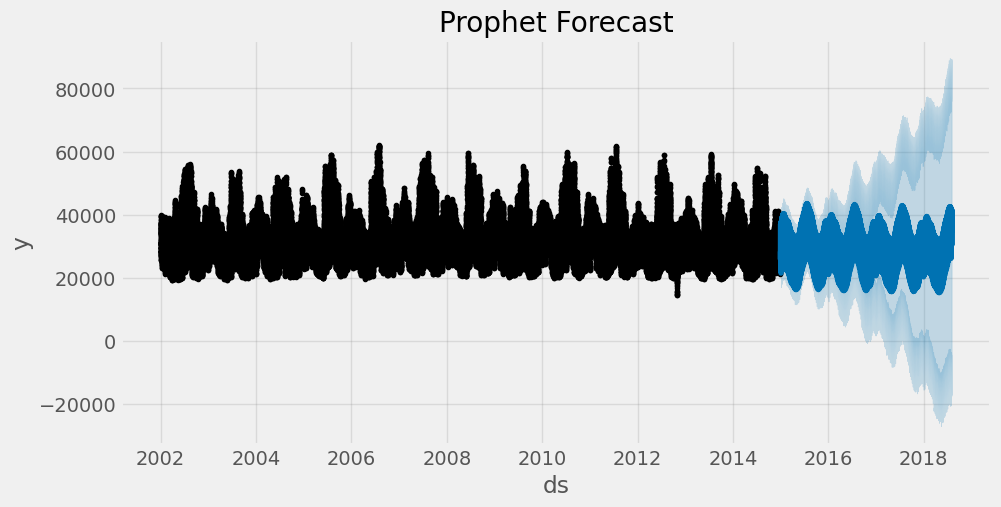

In [227]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

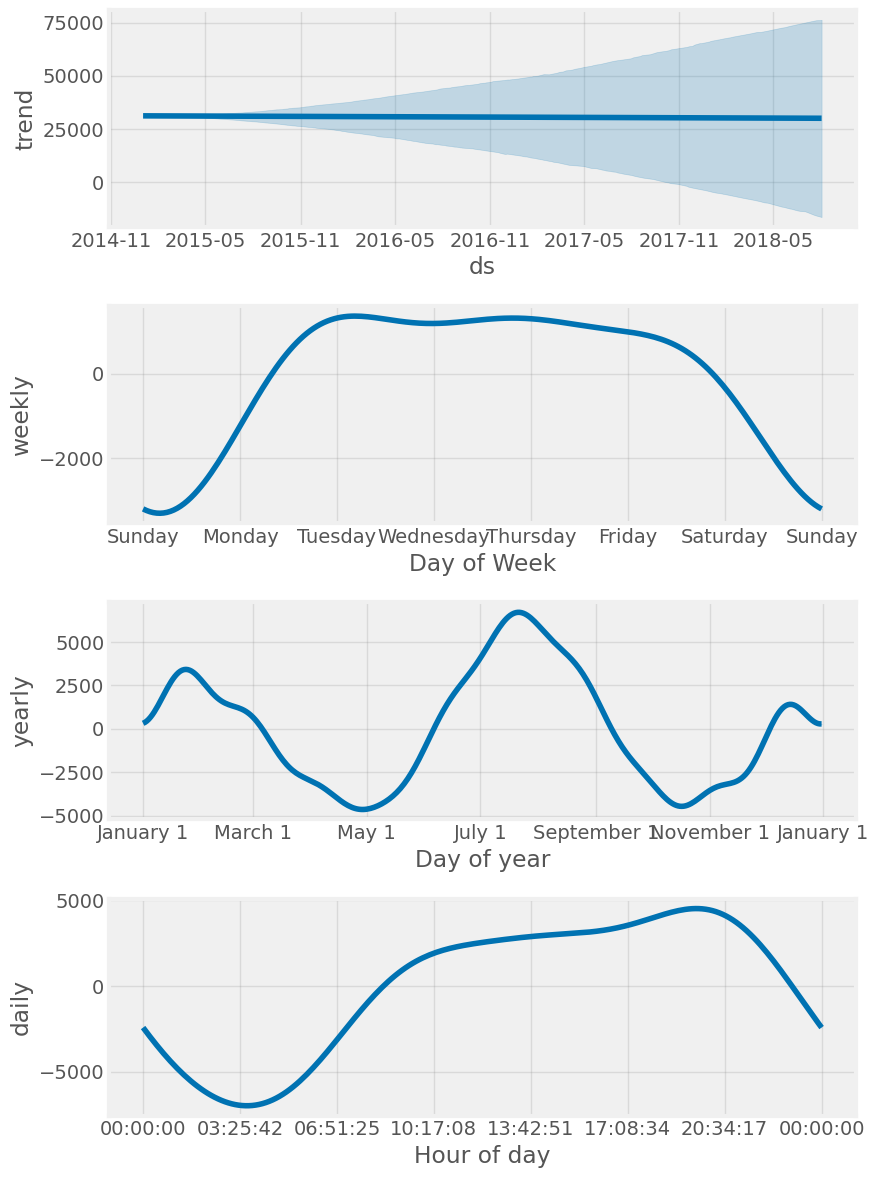

In [228]:
fig = model.plot_components(pjme_test_fcst)
plt.show()

## **Compare Forecast to Actuals**

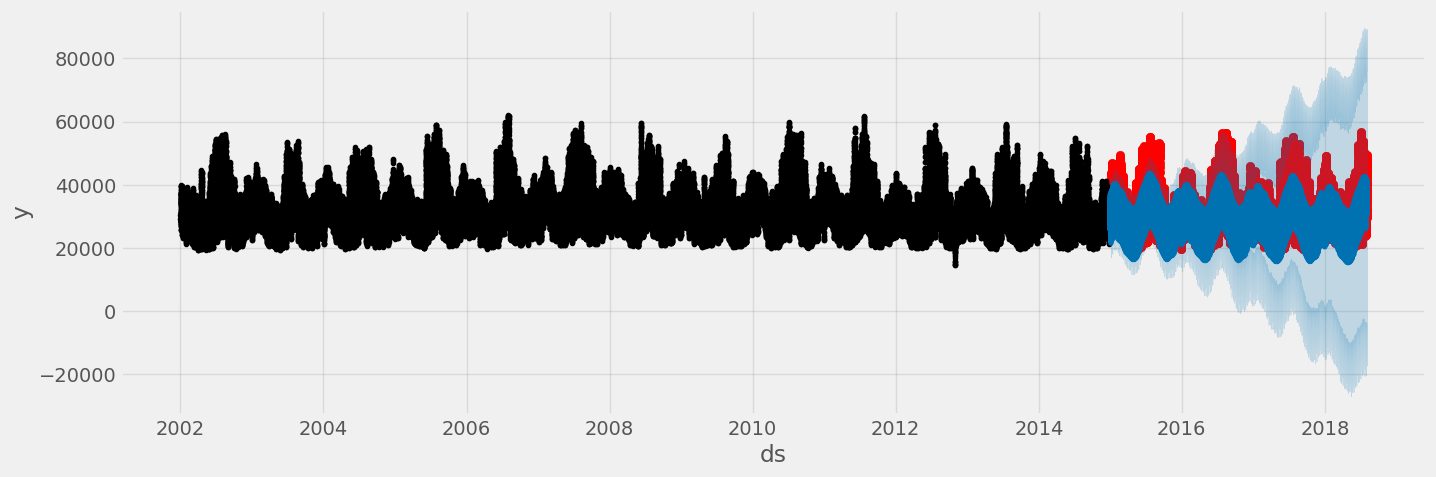

In [229]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)

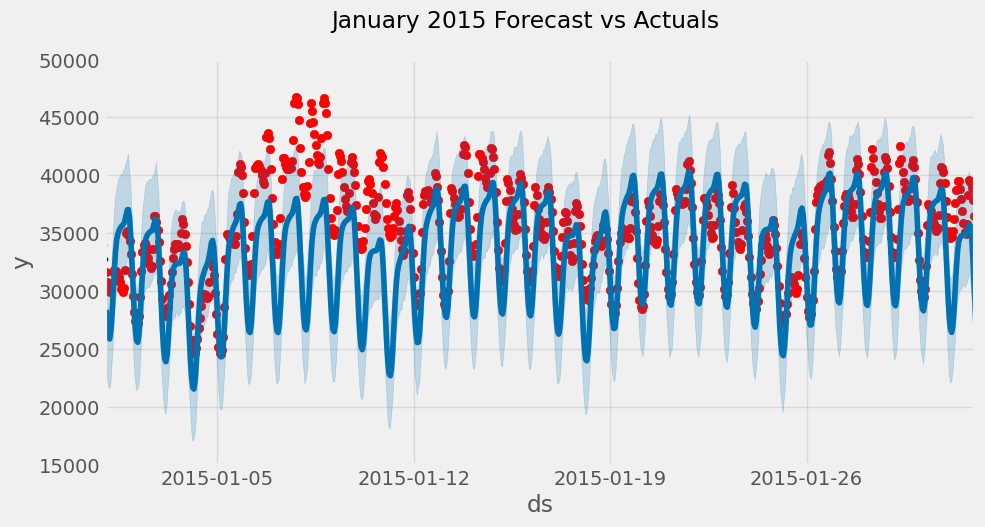

In [230]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_xbound(lower=pd.to_datetime('01-01-2015'), 
              upper=pd.to_datetime('02-01-2015'))
ax.set_ylim(15000, 50000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

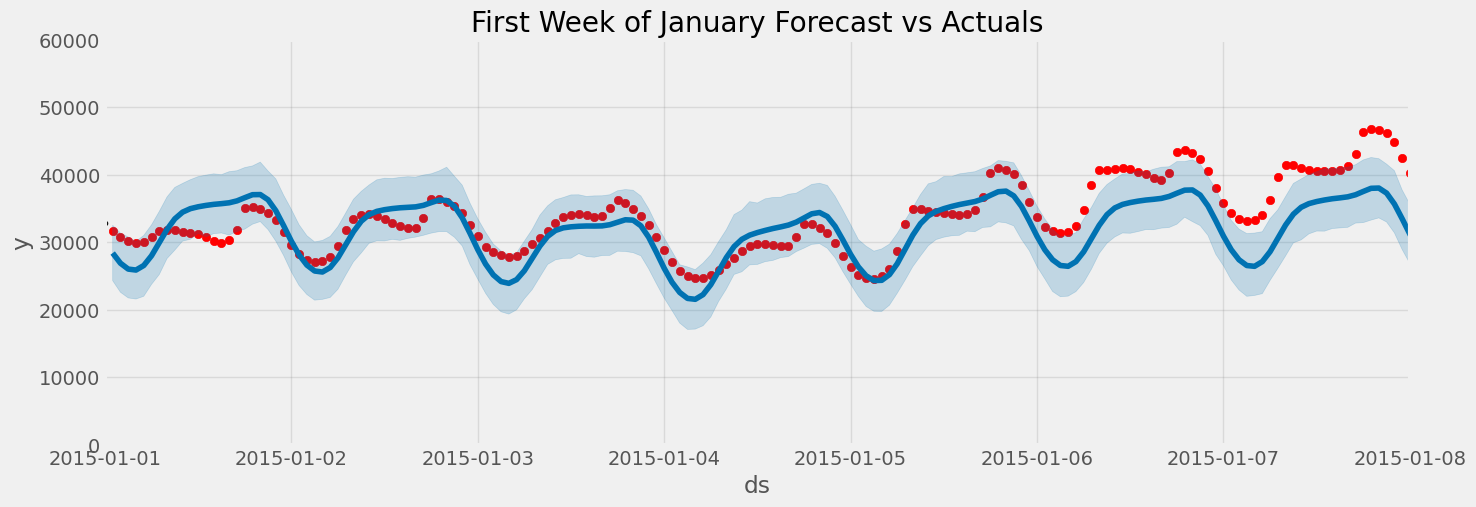

In [231]:
# Plot the forecast of one week with the actuals
f, ax = plt.subplots(figsize=(15,5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_xbound(lower=pd.to_datetime('01-01-2015'), 
              upper=pd.to_datetime('01-08-2015'))
ax.set_ylim(0, 60000)
ax.set_title('First Week of January Forecast vs Actuals')
plt.show()

## **Evaluate the model with Error Metrics**

**Mean Squared Error (MSE)** is a statistical metric that measures the average of the squared difference between predicted values and actual values, quantifying the overall error in a model's predictions. It is always a positive value and is calculated by summing the squared error for each data point and then dividing by the number of data points. A smaller MSE indicates a better fit of the model to the data, meaning predictions are closer to the truth values. 

$$ MSE = \frac{1}{n} \sum_{i=1}^n \left(Y_i - Y_{i}^{\wedge} \right)$$

**Mean Absolute Error (MAE)** is a metric that measures the average magnitude of errors between predicted and actual values in a dataset, calcuated as the average of the absolute difference between each pair of values. It provides a straightforward, absolute measurement of prediction errors in the same units as the data, making useful for understanding how well a model aligns with observed outcomes. 

$$ MAE = \frac{\sum_{i=1}^n \big| y_i - x_i \big|}{n} = \frac{\sum_{i=1}^n \big| e_i\big|}{n}$$

In [232]:
np.sqrt(mean_squared_error(y_true=pjme_test['PJME_MW'],
                           y_pred=pjme_test_fcst['yhat']))

np.float64(4118.468429453338)

In [233]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                    y_pred=pjme_test_fcst['yhat'])

3104.674028374581

**MAE** = 3104.67 
* On average, <span style="color:red;">forecasts are off by 3105 MW</span>.
* For example, if demand is usually ~30,000 MW, then being off by ~3,105 MW is significant.

In [234]:
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                               y_pred=pjme_test_fcst['yhat'])

np.float64(9.62428122042282)

**Mean Absolute Percentage Error (MAPE)** = 9.62%
* On average, forecasts are <span style="color:red;">9.62% away from the actual values</span>.
* This gives a relative error measure, which is easier to compare accross different scales.
* In practice: if demand is 20,000 MW, forecast is typically off by about 1,926 MW (~ 9.62% ).

## **Adding Holidays**
Next we will see if adding holiday indicators will help the accuracy of the model. Prophet comes with a Holiday Effects parameter that can be provided to the model prior to training. 

We will use the build in pandas USFederalHolidayCalendar to pull the list of holidays.

In [235]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

In [236]:
cal = calendar()
holidays = cal.holidays(start=pjme.index.min(),
                  end=pjme.index.max(),
                  return_name=True)

In [237]:
holidays

2002-01-21    Birthday of Martin Luther King, Jr.
2002-02-18                  Washington's Birthday
2002-05-27                           Memorial Day
2002-07-04                       Independence Day
2002-09-02                              Labor Day
                             ...                 
2018-01-01                         New Year's Day
2018-01-15    Birthday of Martin Luther King, Jr.
2018-02-19                  Washington's Birthday
2018-05-28                           Memorial Day
2018-07-04                       Independence Day
Length: 164, dtype: object

In [238]:
type(holidays)

pandas.core.series.Series

In [239]:
holidays.shape

(164,)

In [240]:
holidays[0]

'Birthday of Martin Luther King, Jr.'

In [241]:
holiday_df = pd.DataFrame(data=holidays,
                          columns=['holiday'])

In [242]:
holiday_df.index

DatetimeIndex(['2002-01-21', '2002-02-18', '2002-05-27', '2002-07-04',
               '2002-09-02', '2002-10-14', '2002-11-11', '2002-11-28',
               '2002-12-25', '2003-01-01',
               ...
               '2017-09-04', '2017-10-09', '2017-11-10', '2017-11-23',
               '2017-12-25', '2018-01-01', '2018-01-15', '2018-02-19',
               '2018-05-28', '2018-07-04'],
              dtype='datetime64[ns]', length=164, freq=None)

In [243]:
holidays.index

DatetimeIndex(['2002-01-21', '2002-02-18', '2002-05-27', '2002-07-04',
               '2002-09-02', '2002-10-14', '2002-11-11', '2002-11-28',
               '2002-12-25', '2003-01-01',
               ...
               '2017-09-04', '2017-10-09', '2017-11-10', '2017-11-23',
               '2017-12-25', '2018-01-01', '2018-01-15', '2018-02-19',
               '2018-05-28', '2018-07-04'],
              dtype='datetime64[ns]', length=164, freq=None)

In [244]:
# reset index and renaming it to ds for prophet model
holiday_df = holiday_df.reset_index().rename(columns={'index':'ds'})

In [245]:
holiday_df

,ds,holiday
0,2002-01-21,"Birthday of Martin Luther King, Jr."
1,2002-02-18,Washington's Birthday
2,2002-05-27,Memorial Day
3,2002-07-04,Independence Day
4,2002-09-02,Labor Day
...,...,...
159,2018-01-01,New Year's Day
160,2018-01-15,"Birthday of Martin Luther King, Jr."
161,2018-02-19,Washington's Birthday
162,2018-05-28,Memorial Day


In [246]:
holiday_df.index

RangeIndex(start=0, stop=164, step=1)

## **Training Model with Holidays**

In [247]:
%%time
model_with_holidays = Prophet(holidays=holiday_df)
model_with_holidays.fit(pjme_train_prophet)

17:58:53 - cmdstanpy - INFO - Chain [1] start processing
17:59:39 - cmdstanpy - INFO - Chain [1] done processing


CPU times: user 3.22 s, sys: 77.6 ms, total: 3.3 s
Wall time: 49.9 s


In [248]:
# Predict on training set with model 
pjme_test_fcst_with_hols = model_with_holidays.predict(df=pjme_test_prophet)

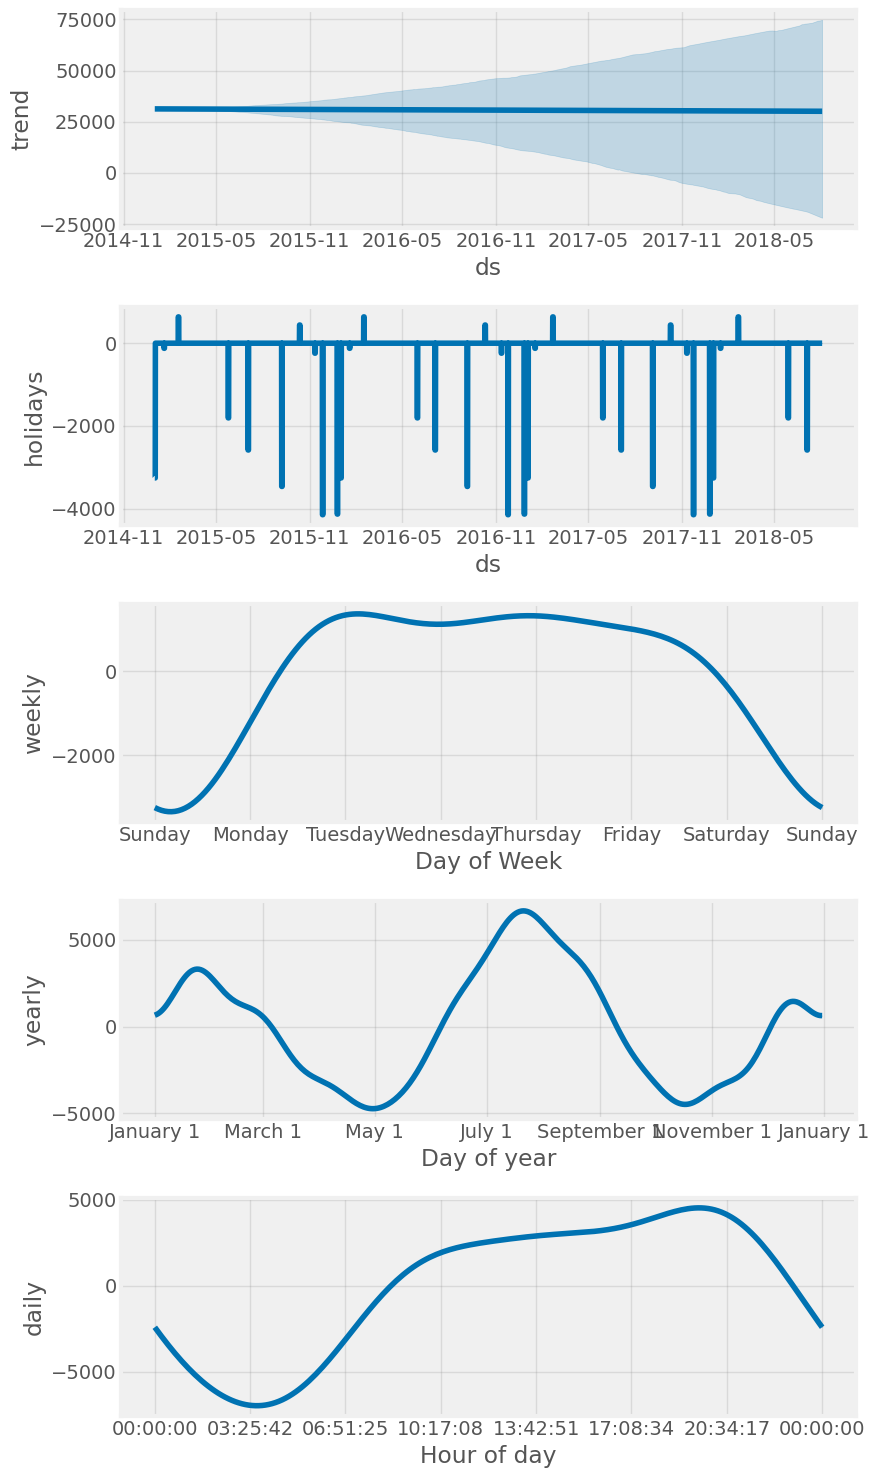

In [249]:
fig = model_with_holidays.plot_components(pjme_test_fcst_with_hols)
plt.show()

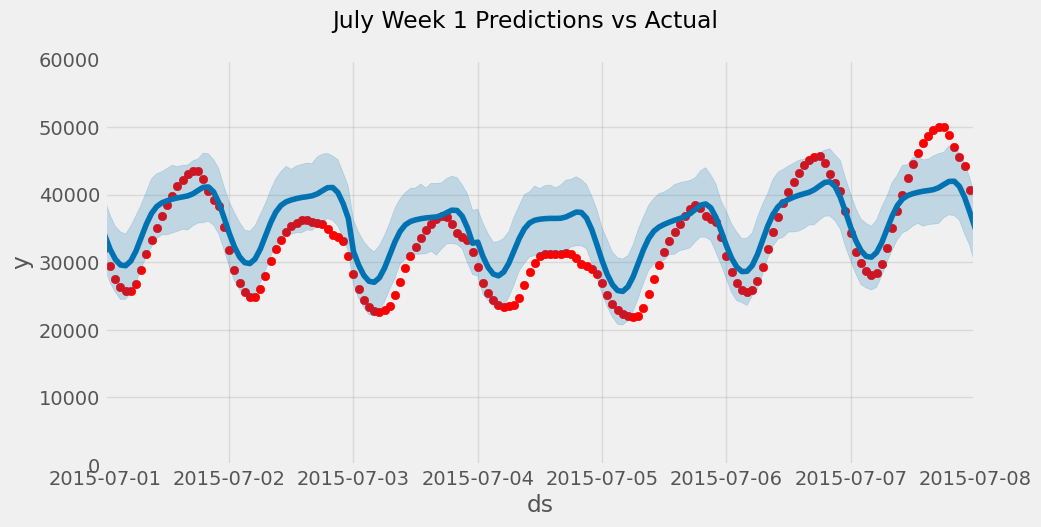

In [250]:
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(pjme_test.index,
           pjme_test['PJME_MW'],
           color='r')
fig = model.plot(pjme_test_fcst_with_hols, ax=ax)
ax.set_xbound(
    lower=pd.to_datetime('07-01-2015'),
    upper=pd.to_datetime('07-08-2015'))
ax.set_ylim(0,60000)
plot = plt.suptitle('July Week 1 Predictions vs Actual')

In [251]:
# Mean Squared Error
np.sqrt(
    mean_squared_error(
        y_true=pjme_test['PJME_MW'],
        y_pred=pjme_test_fcst_with_hols['yhat']
    )
)

np.float64(4102.291456070089)

In [252]:
mean_absolute_error(
    y_true=pjme_test['PJME_MW'],
    y_pred=pjme_test_fcst_with_hols['yhat']
)

3094.7907482232686

**MAE** after adding holidays = 3094 < 3104 = **MAE** before adding holidays

In [253]:
mean_absolute_percentage_error(
    y_true=pjme_test['PJME_MW'],
    y_pred=pjme_test_fcst_with_hols['yhat']
)

np.float64(9.59229194350709)

# **Performance increase of the model after dataset was corrected**

Dataset index was not sorted, while splitting the dataset into train and test, the entire index got jumbled up. <br>
Train Data split should ideally end at `01-Jan-2015` instead it was ending at `01-Jan-2014` <br>
Test Data split should ideally start at `02-Jan-2015`, instead it was ending at `31-Dec-2015` <br>

This issue was solved by `pjme = pjme.sort_index()`

## **Predict into the Future**
We can use the built in `make_future_dataframe` method to build our future dataframe and make predictions.

In [254]:
future = model.make_future_dataframe(periods=7*24, freq='h', include_history=False)
forecast = model_with_holidays.predict(future)

In [255]:
forecast[['ds','yhat']].shape

(168, 2)

In [262]:
pjme_test.head()

,PJME_MW
Datetime,
2015-01-01 01:00:00,31647.0
2015-01-01 02:00:00,30755.0
2015-01-01 03:00:00,30189.0
2015-01-01 04:00:00,29890.0
2015-01-01 05:00:00,30075.0


In [258]:
forecast[['ds','yhat']].tail()

,ds,yhat
163,2015-01-07 20:00:00,38268.699100
164,2015-01-07 21:00:00,37522.310045
165,2015-01-07 22:00:00,35917.988968
166,2015-01-07 23:00:00,33733.741264
167,2015-01-08 00:00:00,31430.426227


In [263]:
pjme_train.tail()

,PJME_MW
Datetime,
2014-12-31 20:00:00,37772.0
2014-12-31 21:00:00,36602.0
2014-12-31 22:00:00,35326.0
2014-12-31 23:00:00,34003.0
2015-01-01 00:00:00,32802.0


In [267]:
pjme_test_week1 = pjme_test_prophet.loc[pjme_test.index <= '2015-01-07']

In [274]:
pjme_test_week1

,ds,y
0,2015-01-01 01:00:00,31647.0
1,2015-01-01 02:00:00,30755.0
2,2015-01-01 03:00:00,30189.0
3,2015-01-01 04:00:00,29890.0
4,2015-01-01 05:00:00,30075.0
...,...,...
139,2015-01-06 20:00:00,43252.0
140,2015-01-06 21:00:00,42315.0
141,2015-01-06 22:00:00,40568.0
142,2015-01-06 23:00:00,38036.0


In [271]:
pd.to_datetime('01-07-2015')

Timestamp('2015-01-07 00:00:00')

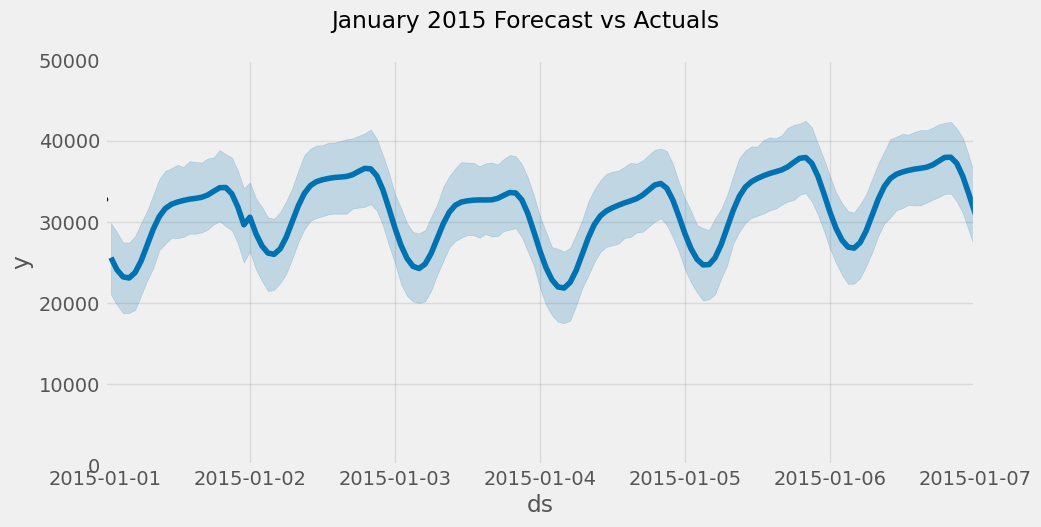

In [275]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(pjme_test_week1.index, pjme_test_week1['y'], color='r')
fig = model.plot(forecast, ax=ax)
ax.set_xbound(lower=pd.to_datetime('01-01-2015'),
              upper=pd.to_datetime('01-07-2015'))
ax.set_ylim(0, 50000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

In [106]:
pjme_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 01:00:00,31210.530967,23824.318755,32730.993762,31210.530967,31210.530967,-2893.742472,-2893.742472,-2893.742472,-4430.272423,-4430.272423,-4430.272423,1281.328732,1281.328732,1281.328732,255.201219,255.201219,255.201219,0.0,0.0,0.0,28316.788495
1,2015-01-01 02:00:00,31210.494154,22105.611865,31168.377505,31210.494154,31210.494154,-4398.239425,-4398.239425,-4398.239425,-5927.272577,-5927.272577,-5927.272577,1272.574102,1272.574102,1272.574102,256.459050,256.459050,256.459050,0.0,0.0,0.0,26812.254729
2,2015-01-01 03:00:00,31210.457342,21491.205011,30819.435915,31210.457342,31210.457342,-5269.974485,-5269.974485,-5269.974485,-6790.346308,-6790.346308,-6790.346308,1262.613389,1262.613389,1262.613389,257.758434,257.758434,257.758434,0.0,0.0,0.0,25940.482857
3,2015-01-01 04:00:00,31210.420529,21155.535701,30260.187677,31210.420529,31210.420529,-5411.456410,-5411.456410,-5411.456410,-6922.126021,-6922.126021,-6922.126021,1251.570211,1251.570211,1251.570211,259.099400,259.099400,259.099400,0.0,0.0,0.0,25798.964119
4,2015-01-01 05:00:00,31210.383716,21704.418953,30636.379714,31210.383716,31210.383716,-4737.018106,-4737.018106,-4737.018106,-6237.080479,-6237.080479,-6237.080479,1239.580401,1239.580401,1239.580401,260.481971,260.481971,260.481971,0.0,0.0,0.0,26473.365610
